# MCMC Recovery 3

This is another trial of MCMC fitting.

In [21]:
import lightkurve
from lightkurve import KeplerTargetPixelFile
from lightkurve import KeplerLightCurve
import matplotlib.pyplot as plt
import lightkurve.injection as inj
from lightkurve.injection import SupernovaModel
import numpy as np
import emcee
import corner

import os
import glob

% matplotlib inline
%load_ext autoreload
%autoreload 
%config InlineBackend.figure_format = 'retina'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
tpf = KeplerTargetPixelFile.from_archive(220381074) 

lc = tpf.to_lightcurve(aperture_mask='all') 
lc = lc.remove_nans().remove_outliers() 

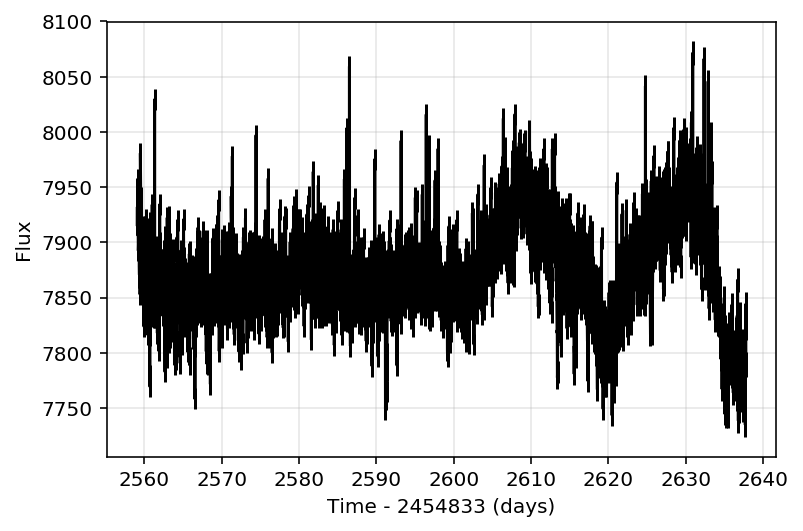

In [23]:
lc.plot(normalize=False)

In [24]:
model = inj.SupernovaModel(T0=2600, source='hsiao', bandpass='kepler', z=0.5, amplitude=7e-7)
lcinj = inj.inject(lc, model)

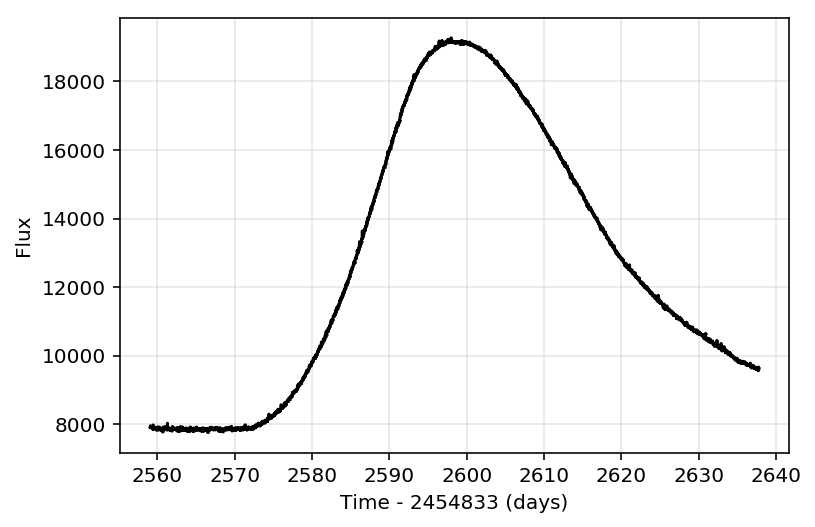

In [25]:
lcinj = lcinj.remove_nans()
lcinj.plot(normalize=False)

In [53]:
def lnlike(theta, x, y, yerr):
    """ Define ln likelihood
    
    Parameters:
    ----------- 
    T0: SN 
    z: redshift
    amplitude: amplitude
    x : time (lcinj.time)
    y : injected flux (lcinj.flux)
    yerr : flux error (lcinj.flux_err)
    model: supernova model
    """
    T0, z, amplitude = theta # Parameters fitting for 
    if (z < 0) or (z > 1):
        return -np.inf
    model = SupernovaModel(T0, z=z, amplitude=amplitude)
    model = model.evaluate(x) + 7800
    residual = (y - model) 
    return -0.5*(np.sum(residual**2/yerr**2)) # estimate chi2 


def lnprob(theta, x, y, yerr):
    """Define ln probability"""
    return lnlike(theta, x, y, yerr)

ndim, nwalkers = 3, 20

In [60]:
initial_T0 = 2600
initial_z = 0.5
initial_amplitude = 7.e-7
n_steps = 1000 # Steps for Emcee

theta_init = [initial_T0, initial_z, initial_amplitude]

theta_guess = np.zeros(shape=(nwalkers, ndim))
theta_guess[:, 0] = np.random.normal(theta_init[0], 0.01, nwalkers)
theta_guess[:, 1] = np.random.normal(theta_init[1], 0.01, nwalkers)
theta_guess[:, 2] = np.random.normal(theta_init[2], 0.01, nwalkers)


# Sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(lcinj.time, lcinj.flux, lcinj.flux_err))




In [61]:
sampler.run_mcmc(theta_guess,n_steps)

(array([[2.60018357e+03, 5.19577088e-01, 7.07704714e-07],
        [2.60018477e+03, 5.19700030e-01, 7.07763269e-07],
        [2.60018208e+03, 5.19403685e-01, 7.07703662e-07],
        [2.60018196e+03, 5.19401749e-01, 7.07700975e-07],
        [2.60018197e+03, 5.19272663e-01, 7.07684817e-07],
        [2.60018199e+03, 5.19349352e-01, 7.07744446e-07],
        [2.60018279e+03, 5.19413840e-01, 7.07679869e-07],
        [2.60018000e+03, 5.19153529e-01, 7.07717164e-07],
        [2.60018416e+03, 5.19609369e-01, 7.07722665e-07],
        [2.60018123e+03, 5.19300805e-01, 7.07736557e-07]]),
 array([-51472.84276153, -51474.10141392, -51471.36811058, -51471.67459351,
        -51473.51222207, -51471.9824346 , -51473.40063392, -51473.06169077,
        -51471.9531166 , -51472.12461398]),
 ('MT19937', array([3620204525, 1763936987, 4111745616, 2819341114, 3462438651,
         4129000250,  832217744, 1182512837, 3642819866, 1410997584,
         2695793994,  492065011, 1920193577,  962789015, 1004216201,
    

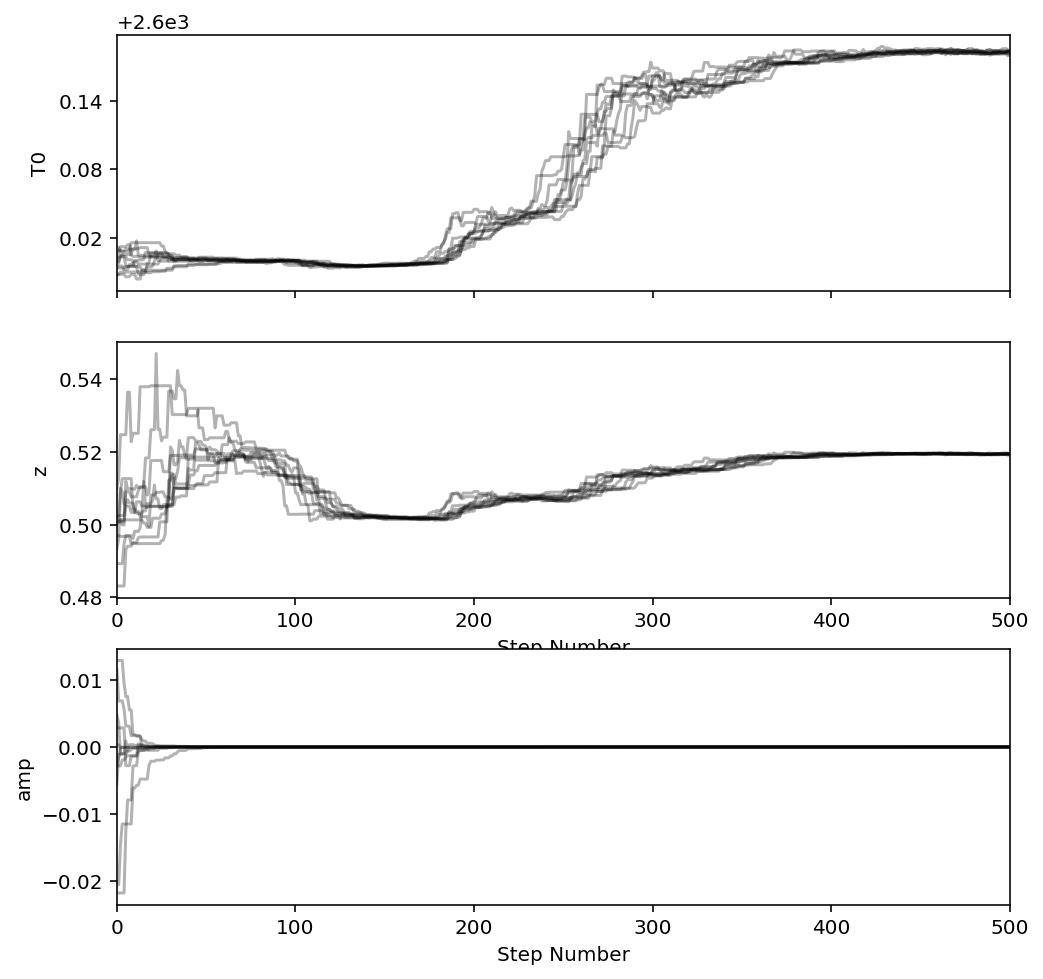

In [62]:
from matplotlib.ticker import MaxNLocator

samples = sampler.chain
labels = ['T0', 'z', 'amp']

fig1 = plt.figure(figsize=[8, 8])
for i in range(samples.shape[-1]):
    ax = fig1.add_subplot(3, 1, i + 1)
    ax.plot(sampler.chain[:, 0:1000, i].T, "k", alpha=0.3)
    ax.set_xlim(0, sampler.chain.shape[1])
    if i < 1:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel("Step Number")
    ax.set_ylabel(labels[i])
    ax.yaxis.set_major_locator(MaxNLocator(4))

    plt.xlim(0, 500)
fig1.show()

In [57]:
samples = sampler.chain[:, 0:, :].reshape((-1, ndim))

In [58]:
print(samples)

[[ 2.59999896e+03  4.99122704e-01  5.74478537e-03]
 [ 2.60000339e+03  5.02586627e-01 -2.10219765e-03]
 [ 2.60000339e+03  5.02586627e-01 -2.10219765e-03]
 ...
 [ 2.60003751e+03  5.05010227e-01  7.07026864e-07]
 [ 2.60003836e+03  5.05038094e-01  7.07079367e-07]
 [ 2.60003836e+03  5.05038094e-01  7.07079367e-07]]


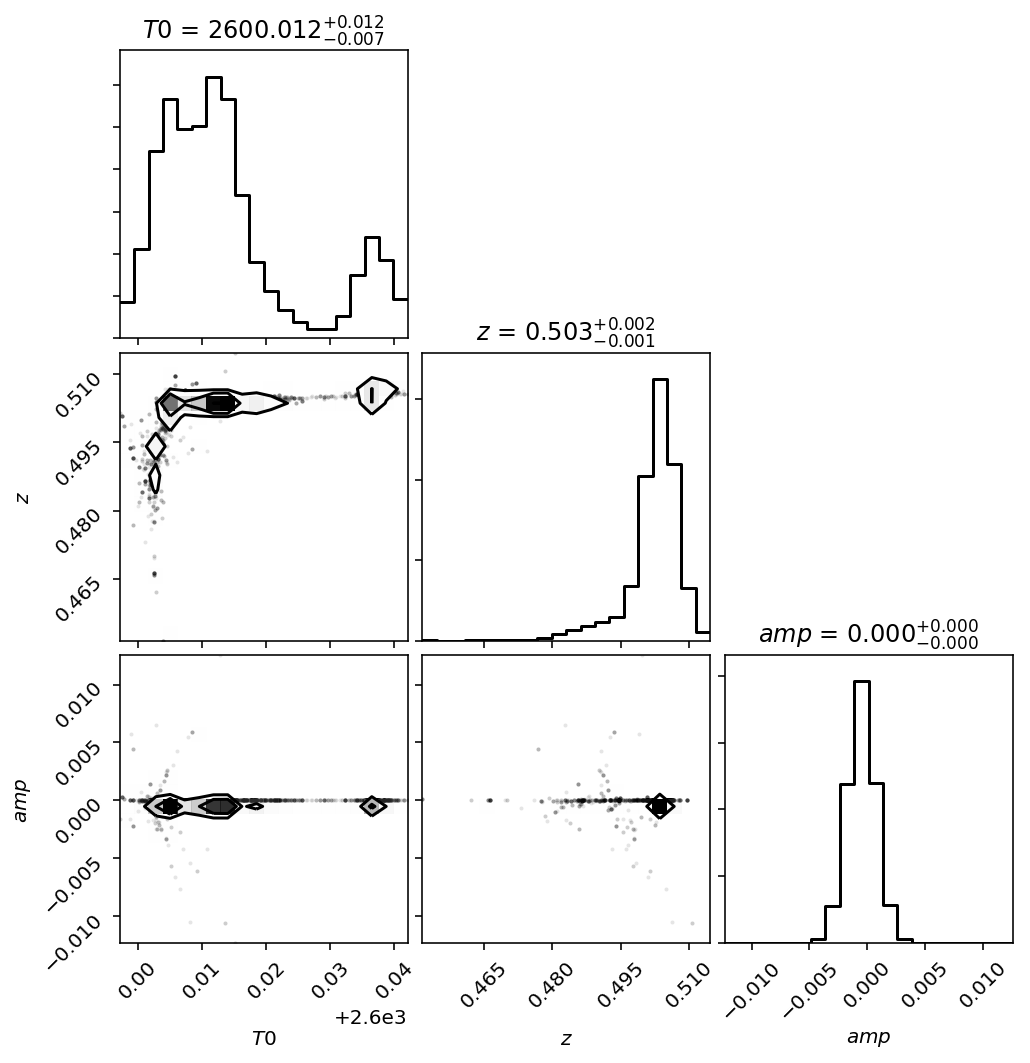

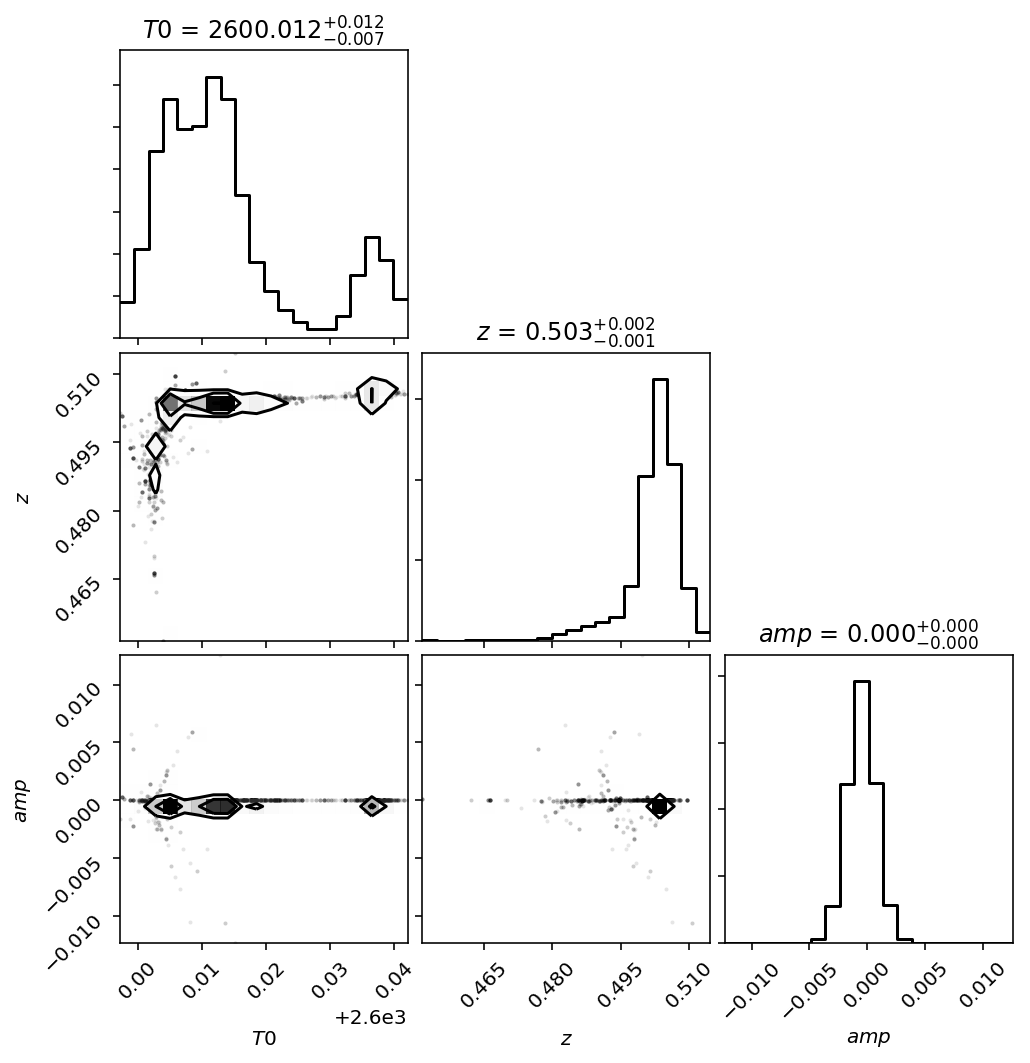

In [59]:
corner.corner(samples[:], labels=["$T0$", "$z$", "$amp$"], smooth1d=True,
             show_titles=True, max_n_ticks=5,title_fmt='.3f',color='k')
